![Screenshot 2025-09-04 212553.png](<attachment:Screenshot 2025-09-04 212553.png>)
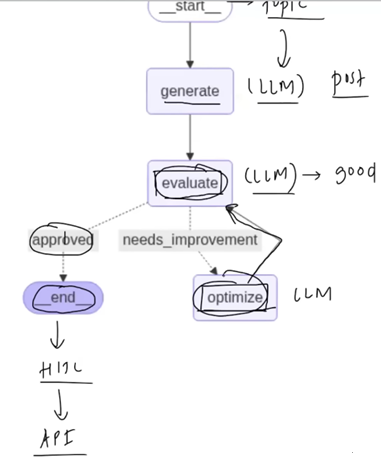

### Here we need 3 LLMs:

1. **generate** -> will generate the post


2. **evaluate** -> will evaluate how good/bad the post is


3. **optimize** -> if not satisfactory then another LLM will optimize it.

In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
from dotenv import load_dotenv

import operator

In [2]:
from pydantic import BaseModel, Field

In [3]:
load_dotenv()

True

In [4]:
generator_llm = ChatOpenAI(model='gpt-4o-mini')
evaluate_llm = ChatOpenAI(model="gpt-4o")
optimizer_llm = ChatOpenAI(model='gpt-4o-mini')

In [5]:
# State

class TweetState(TypedDict):
    
    topic : str
    tweet : str
    evaluation : Literal['approved','needs_improvement']
    feedback : str
    iteration : int
    max_iteration : int
    
    # history of all generated tweets
    tweet_history : Annotated[list[str], operator.add]
    feedback_history : Annotated[list[str], operator.add] # all feedbacks will be added here

In [6]:
def generate_tweet(state : TweetState):
    
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""Write a short, original, and hilarious tweet on the topic: "{state['topic']}".
                     Rules:
                     - Do NOT use question-answer format.
                     - Max 280 characters.
                     - Use observational humor, irony, sarcasm, or cultural references.
                     - Think in meme logic, punchlines, or relatable takes.
                     - Use simple, day to day english
                     """)
        ]
    
    # send generator_llm
    
    response = generator_llm.invoke(messages).content
    
    # return response
    
    return {'tweet' : response, 'tweet_history' : [response]} # add all tweet in tweet history as a list


In [7]:
# for structured_output from evaluate_tweet results

from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    
    evaluation : Literal['approved','needs_improvement'] = Field(..., description = 'Final evaluation result.')
    feedback : str = Field(..., description = 'feedback for the tweet.') 

In [8]:
structured_evaluator_llm = evaluate_llm.with_structured_output(TweetEvaluation)

In [9]:
# need a structured_output to result from llm

def evaluate_tweet(state : TweetState):
    
    # prompt with evaluation criteria
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
                 Evaluate the following tweet:
                 Tweet: "{state['tweet']}"
                 
                 Use the criteria below to evaluate the tweet:
                 1. Originality – Is this fresh, or have you seen it a hundred times before?  
                 2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
                 3. Punchiness – Is it short, sharp, and scroll-stopping?  
                 4. Virality Potential – Would people retweet or share it?  
                 5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?
                 
                 Auto-reject if:
                 - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
                 - It exceeds 280 characters
                 - It reads like a traditional setup-punchline joke
                 - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)
                 
                 ### Respond ONLY in structured format:
                 - evaluation: "approved" or "needs_improvement"  
                 - feedback: One paragraph explaining the strengths and weaknesses.""")
    ]
    
    # evaluation result
    response = structured_evaluator_llm.invoke(messages)
    
    return {'evaluation' : response.evaluation, 'feedback' : response.feedback, 'feedback_history': [response.feedback]}

In [10]:
# optimize tweet


def optimize_tweet(state : TweetState):
    
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""Improve the tweet based on this feedback:"{state['feedback']}"
                     
                     Topic: "{state['topic']}" 
                     Original Tweet: {state['tweet']}
                     
                     Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.""")
        ]
    
    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1
    
    return {'tweet' : response, 'iteration' : iteration, 'tweet_history' : [response]}
    

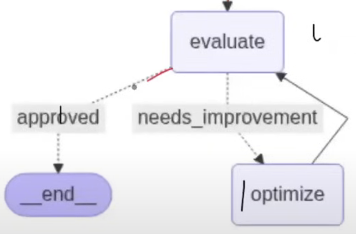

In [11]:
# function to create the conditional edge from evaluation to either approved or needs_improvement

def route_evaluation(state : TweetState):
    
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

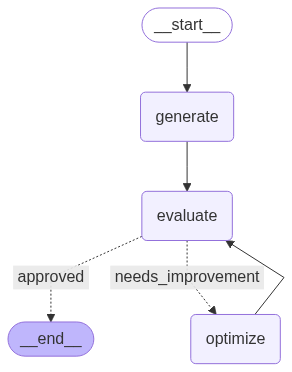

In [12]:
graph = StateGraph(TweetState)


# nodes

graph.add_node('generate',generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)


# edges

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

## conditional edge based on output of evaluate node
graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'}) # here it is conditional edge with routing
graph.add_edge('optimize', 'evaluate')


workflow = graph.compile()

workflow


In [13]:
initial_state = {
    "topic": "Life is sad and depressing",
    "iteration": 1,
    "max_iteration": 5
}

result = workflow.invoke(initial_state)

In [14]:
result

{'topic': 'Life is sad and depressing',
 'tweet': 'Life’s a tragic drama 🎬, and Netflix is my happy place—dive into the pool of joy while the fridge’s horror show waits backstage! 🍿 Here I am, munching on “I’ll regret this later” popcorn, blissfully ignoring my salad’s tearful pleas. #BingeEscape ',
 'evaluation': 'needs_improvement',
 'feedback': "The tweet attempts an amalgamation of observational humor and metaphor, which is conceptually interesting but somewhat cliché. The idea of Netflix being a refuge from life's difficulties is a common theme, lacking robust originality. Its humor is mild at best and seemed forced with phrasing like 'blissfully ignoring my salad’s tearful pleas,' which tries to be whimsical but falls flat. Although it could resonate with audiences who can relate to binge-watching, its length and flow hinder punchiness, and it doesn't carry a significant virality potential due to its overused premise and predictable pattern. It strives to engage but ends up as a 

In [15]:
result['topic']

'Life is sad and depressing'

In [16]:
result['tweet']

'Life’s a tragic drama 🎬, and Netflix is my happy place—dive into the pool of joy while the fridge’s horror show waits backstage! 🍿 Here I am, munching on “I’ll regret this later” popcorn, blissfully ignoring my salad’s tearful pleas. #BingeEscape '

In [17]:
result['evaluation']

'needs_improvement'

In [18]:
result['feedback']

"The tweet attempts an amalgamation of observational humor and metaphor, which is conceptually interesting but somewhat cliché. The idea of Netflix being a refuge from life's difficulties is a common theme, lacking robust originality. Its humor is mild at best and seemed forced with phrasing like 'blissfully ignoring my salad’s tearful pleas,' which tries to be whimsical but falls flat. Although it could resonate with audiences who can relate to binge-watching, its length and flow hinder punchiness, and it doesn't carry a significant virality potential due to its overused premise and predictable pattern. It strives to engage but ends up as a cluttered narrative rather than a concise, impactful statement. Format-wise, it sticks to the character limit but could improve by being more succinct, engaging, and novel."

In [28]:
for index, tweet in enumerate(result['tweet_history']):
    print(f'{index+1}. {tweet}')
    print("\n")

1. Life is sad and depressing, but luckily my Netflix account is still active. Nothing like binge-watching fictional happiness to make you forget your own melodrama...until you remember you're still out of snacks. #DistractYourself 🍕😂


2. Life can feel like a never-ending sad film 🎬, but luckily my Netflix is the best escape—like diving into a pool of fictional joy! Just don’t check the fridge; that’s a horror movie waiting to happen. Just me, the TV, and a bag of regret... err, popcorn. 🍿 #BingeEscape


3. Life's a sad film 🎬, but my Netflix is the ultimate escape—like jumping into a pool of fictional joy! Just don’t open the fridge; that’s a horror flick I’m not ready for! It’s just me, the TV, and a bowl of regret-flavored popcorn. 🍿 #BingeEscape


4. Life’s a sad film 🎬, and Netflix is my escape—the pool of joy I jump into while avoiding the fridge’s horror show! 🍿 Just me and my bowl of “I definitely should’ve eaten that salad” popcorn. #BingeEscape


5. Life’s a tragic drama 🎬, 

In [29]:
for index, feedback in enumerate(result['feedback_history']):
    print(f'{index+1}. {feedback}')
    print("\n")

1. The tweet attempts humor by connecting the relatable feelings of sadness with the escapism offered by Netflix, which is a fairly common theme on social media. While the idea of searching for happiness in streaming services is relatable, it lacks originality and doesn't offer a fresh perspective. The humor is mild and feels forced rather than genuinely funny. The use of an emoji and a hashtag adds some engagement elements, but it doesn't significantly boost its virality potential. 'Until you remember you're still out of snacks' is a flat concluding line, which dilutes any potential punchiness it might have had. It complies with the format guidelines but remains largely forgettable.


2. The tweet attempts to mix humor and relatability with the mention of Netflix as an escape and the fridge as a 'horror movie,' which is a common trope. While these elements may resonate with everyday experiences, the humor feels a bit forced and lacks originality. It employs a longer format that meande